In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from torchsummary import summary
import os

In [5]:
# Load the Dataset
file_path = "../data/training_data/BTCUSDT/BTCUSDT_2022-01-01_2024-11-01_5.csv"
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
columns_to_keep = ['Timestamp','Close', 'Volume', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Signal','MACD_Hist',
       'RSI', 'BB_upper', 'BB_middle', 'BB_lower']

df_filtered = df[columns_to_keep]
df = df_filtered.dropna()

Model Architecture:
LSTM(
  (lstm_y): LSTM(1, 64, batch_first=True)
  (lstm_p): LSTM(2, 64, batch_first=True)
  (lstm_n): LSTM(2, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Number of trainable parameters:
52,033
Epoch 1/20, Train Loss: 0.000268, Val Loss: 0.000047
Epoch 2/20, Train Loss: 0.000011, Val Loss: 0.000103
Epoch 3/20, Train Loss: 0.000008, Val Loss: 0.000173
Epoch 4/20, Train Loss: 0.000007, Val Loss: 0.000049
Epoch 5/20, Train Loss: 0.000006, Val Loss: 0.000066
Epoch 6/20, Train Loss: 0.000006, Val Loss: 0.000028
Epoch 7/20, Train Loss: 0.000005, Val Loss: 0.000023
Epoch 8/20, Train Loss: 0.000005, Val Loss: 0.000087
Epoch 9/20, Train Loss: 0.000005, Val Loss: 0.000022
Epoch 10/20, Train Loss: 0.000005, Val Loss: 0.000062
Epoch 11/20, Train Loss: 0.000005, Val Loss: 0.000213
Epoch 12/20, Train Loss: 0.000005, Val Loss: 0.000258
Epoch 13/20, Train Loss: 0.000005, Val Loss: 0.000177
Epoch 14/20, Train Loss: 0.000005, Val Loss: 0.000065
E

C:\Users\maxru\AppData\Local\Temp\ipykernel_15872\3033679786.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("MultiInputLSTM_TimeSerie

Saved price predictions plot to ../Evaluation_PNGs/MultiInputLSTM_TimeSeries_price_predictions.png


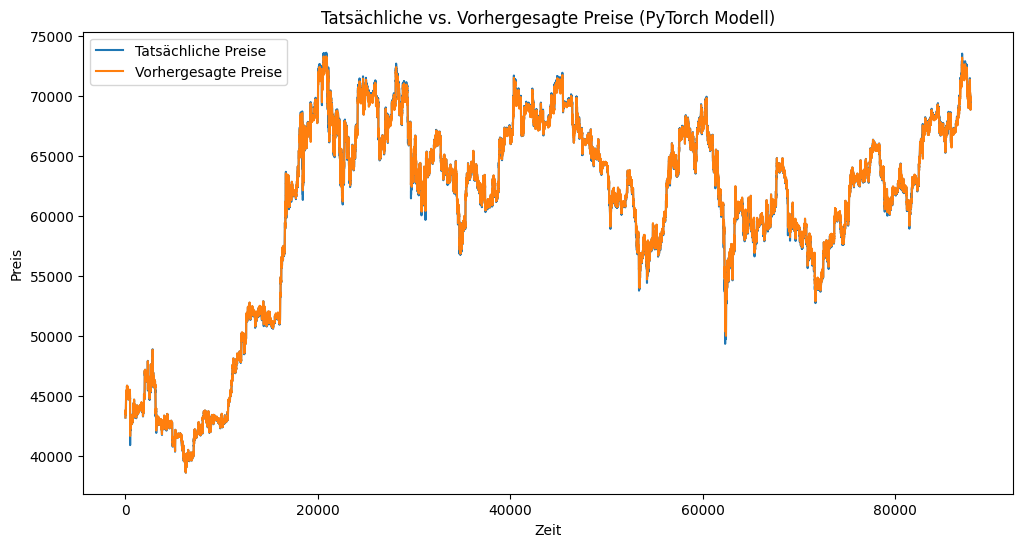

Saved loss curves plot to ../Evaluation_PNGs/MultiInputLSTM_TimeSeries_loss_curves.png


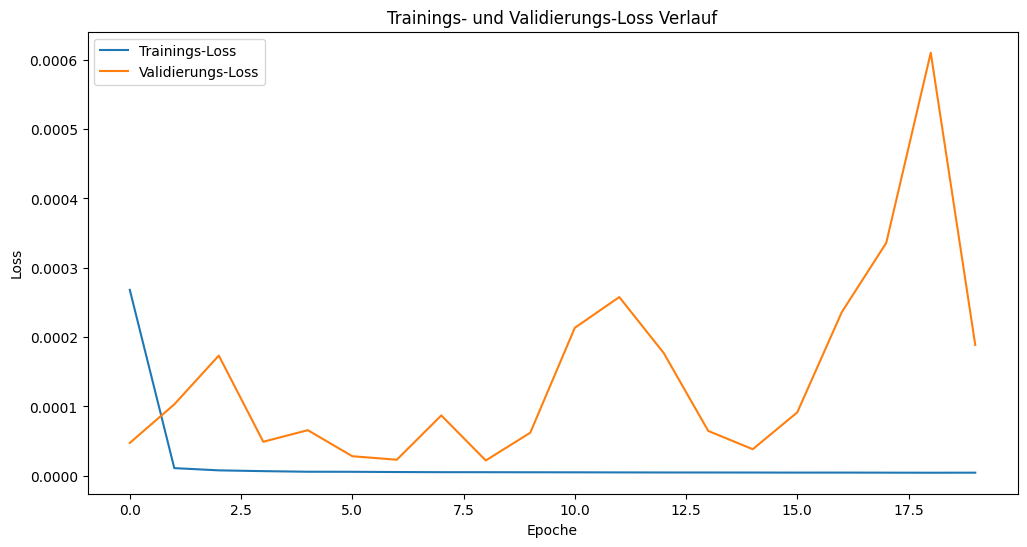

In [6]:
# Feature-Auswahl
features = ['SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'MACD_Signal']
target = 'Close'

# Daten vorbereiten
prices = df['Close'].values.reshape(-1, 1)

# Extrahieren der Features und des Targets
X = df[features].values.copy()
y = df[target].values.copy()

# Normalisierung der Features und des Targets
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Aufteilung in Trainings- und Testdaten
train_size = int(len(X_scaled) * 0.7)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Funktion zur Sequenz-Erstellung
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Sequenzlänge definieren
sequence_length = 60

# Erstellen der Sequenzen
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Dataset und DataLoader für PyTorch
class MultiInputTimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_seq = self.X[idx]
        y_target = self.y[idx]
        Y = X_seq[:, 0].unsqueeze(-1)
        X_p = X_seq[:, 1:3]
        X_n = X_seq[:, 3:5]
        return Y, y_target, X_p, X_n

# DataLoader
batch_size = 64

train_dataset = MultiInputTimeSeriesDataset(X_train_seq, y_train_seq, sequence_length)
test_dataset = MultiInputTimeSeriesDataset(X_test_seq, y_test_seq, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modelldefinition
class LSTM(nn.Module):
    def __init__(self, input_size_pn, hidden_size):
        super(LSTM, self).__init__()
        self.lstm_y = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.lstm_p = nn.LSTM(input_size=input_size_pn, hidden_size=hidden_size, batch_first=True)
        self.lstm_n = nn.LSTM(input_size=input_size_pn, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, Y, X_p, X_n):
        Y_out, _ = self.lstm_y(Y)
        X_p_out, _ = self.lstm_p(X_p)
        X_n_out, _ = self.lstm_n(X_n)
        combined = Y_out[:, -1, :] + X_p_out[:, -1, :] + X_n_out[:, -1, :]
        output = self.fc(combined)
        return output

# Modellinitialisierung
input_size_pn = 2
hidden_size = 64

model = LSTM(input_size_pn=input_size_pn, hidden_size=hidden_size)

def model_summary(model):
    print("Model Architecture:")
    print(model)
    print("\nNumber of trainable parameters:")
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_params:,}")

# Gebe die Modellzusammenfassung aus
model_summary(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for Y, y_target, X_p, X_n in train_loader:
        Y, y_target, X_p, X_n = Y.to(device), y_target.to(device), X_p.to(device), X_n.to(device)

        optimizer.zero_grad()
        predictions = model(Y, X_p, X_n)
        loss = criterion(predictions.squeeze(), y_target.squeeze())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validierung
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Y, y_target, X_p, X_n in test_loader:
            Y, y_target, X_p, X_n = Y.to(device), y_target.to(device), X_p.to(device), X_n.to(device)
            predictions = model(Y, X_p, X_n)
            loss = criterion(predictions.squeeze(), y_target.squeeze())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "MultiInputLSTM_TimeSeries.pth")

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

# Laden des besten Modells
model.load_state_dict(torch.load("MultiInputLSTM_TimeSeries.pth"))

# Vorhersagen erstellen
model.eval()
train_predictions, test_predictions = [], []
with torch.no_grad():
    for Y, y_target, X_p, X_n in train_loader:
        Y, X_p, X_n = Y.to(device), X_p.to(device), X_n.to(device)
        outputs = model(Y, X_p, X_n)
        train_predictions.extend(outputs.cpu().numpy())

    for Y, y_target, X_p, X_n in test_loader:
        Y, X_p, X_n = Y.to(device), X_p.to(device), X_n.to(device)
        outputs = model(Y, X_p, X_n)
        test_predictions.extend(outputs.cpu().numpy())

# Denormalisierung der Vorhersagen
train_predictions = scaler_y.inverse_transform(np.array(train_predictions).reshape(-1, 1))
test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_train_unscaled = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))
y_test_unscaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# Output directory
output_dir = "../Evaluation_PNGs/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Folder '{output_dir}' created for saving the plots.")

# Visualisierung der Ergebnisse
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Tatsächliche Preise')
plt.plot(test_predictions, label='Vorhergesagte Preise')
plt.xlabel('Zeit')
plt.ylabel('Preis')
plt.title('Tatsächliche vs. Vorhergesagte Preise (PyTorch Modell)')
plt.legend()

# Save plot
price_plot_path = os.path.join(output_dir, "MultiInputLSTM_TimeSeries_price_predictions.png")
plt.savefig(price_plot_path)
print(f"Saved price predictions plot to {price_plot_path}")

# Show the plot
plt.show()

# Plot der Trainings- und Validierungsverluste
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Trainings-Loss')
plt.plot(val_losses, label='Validierungs-Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Trainings- und Validierungs-Loss Verlauf')
plt.legend()

# Save plot
loss_plot_path = os.path.join(output_dir, "MultiInputLSTM_TimeSeries_loss_curves.png")
plt.savefig(loss_plot_path)
print(f"Saved loss curves plot to {loss_plot_path}")

# Show the plot
plt.show()